## 1. Load the package

In [1]:
import os, shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from utils.labels_preprocessing import load_labels
from utils.load_synced_inputs import load_inputs
from utils.load_graphs import load_graph

from cnn_graph.resnetgraph import cgcnn
from cnn_graph import graph

import tensorflow as tf

from matplotlib import pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

## 2. Establish Directories for Data Extraction

In [2]:
home = f"{os.getcwd()}/.."

graphs_dir = f"{home}/Graphs/"            # directory containing necessary graphs
cortical_dir = '.../Data/abcd challenge/training/Cortex'

In [4]:
filenames = [f for f in sorted(os.listdir(cortical_dir))]
filenames_2 = [f for f in os.listdir(cortical_dir)]
assert filenames == filenames_2
    
print(len(filenames))
print(len(filenames_2))

8071
8071


## 3. Load Labels

In [6]:
Path = '.../abcd.csv'
df = pd.read_csv(Path)
df_fluid = df[['Subject','Sex','Age','Cognition Fluid Composite Uncorrected Standard Score','Cognition Fluid Composite Age-Corrected Standard Score']]   # choose the columns you want
df_new = df_fluid.dropna(subset=['Cognition Fluid Composite Uncorrected Standard Score'])                                       # drop the Nan rows
df_new.head(8)

,Subject,Sex,Age,Cognition Fluid Composite Uncorrected Standard Score,Cognition Fluid Composite Age-Corrected Standard Score
0,NDAR_INV005V6D2C,F,121,90.0,90.0
1,NDAR_INV007W6H7B,M,126,101.0,104.0
2,NDAR_INV00CY2MDM,M,130,85.0,85.0
3,NDAR_INV00HEV6HB,M,124,90.0,88.0
4,NDAR_INV00LH735Y,M,109,77.0,75.0
5,NDAR_INV00LJVZK2,M,121,86.0,81.0
6,NDAR_INV00NPMHND,F,118,77.0,74.0
7,NDAR_INV00R4TXET,F,114,104.0,118.0


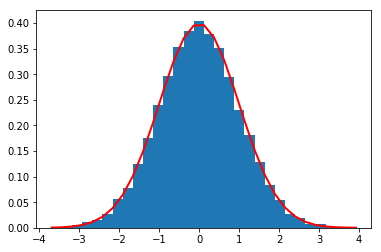

In [7]:
#show the distribution 
s = np.random.normal(0, 1, df_new.shape[0])
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/( np.sqrt(2 * np.pi)) *
                np.exp( - (bins )**2 / (2) ),
          linewidth=2, color='r')
plt.show()

In [8]:
def quantile_normalize_using_target(x, target):
    """
    Both `x` and `target` are numpy arrays of equal lengths.
    """

    target_sorted = np.sort(target)

    return target_sorted[x.argsort().argsort()]

In [9]:
xx = quantile_normalize_using_target(df_new['Cognition Fluid Composite Uncorrected Standard Score'].as_matrix(),s)
encoded_labels = xx
print(encoded_labels)

df_new['CogFluidComp_nor'] = pd.DataFrame({'CogFluidComp_nor': xx})
df_new.head(8)

[-0.24633528  0.81573721 -0.69569488 ...  1.05993638  1.29075842
 -1.94937176]


,Subject,Sex,Age,Cognition Fluid Composite Uncorrected Standard Score,Cognition Fluid Composite Age-Corrected Standard Score,CogFluidComp_nor
0,NDAR_INV005V6D2C,F,121,90.0,90.0,-0.246335
1,NDAR_INV007W6H7B,M,126,101.0,104.0,0.815737
2,NDAR_INV00CY2MDM,M,130,85.0,85.0,-0.695695
3,NDAR_INV00HEV6HB,M,124,90.0,88.0,-0.317715
4,NDAR_INV00LH735Y,M,109,77.0,75.0,-1.422254
5,NDAR_INV00LJVZK2,M,121,86.0,81.0,-0.630846
6,NDAR_INV00NPMHND,F,118,77.0,74.0,-1.416269
7,NDAR_INV00R4TXET,F,114,104.0,118.0,1.177185


In [10]:
filenames = df_new['Subject'].astype('str').as_matrix()
filenames2 = ('Cortex_' + filenames + '.mat').tolist()

filenames3 = [f for f in sorted(filenames2)]
print(filenames3[:10])

print(len(encoded_labels))

['Cortex_NDAR_INV005V6D2C.mat', 'Cortex_NDAR_INV007W6H7B.mat', 'Cortex_NDAR_INV00CY2MDM.mat', 'Cortex_NDAR_INV00HEV6HB.mat', 'Cortex_NDAR_INV00LH735Y.mat', 'Cortex_NDAR_INV00LJVZK2.mat', 'Cortex_NDAR_INV00NPMHND.mat', 'Cortex_NDAR_INV00R4TXET.mat', 'Cortex_NDAR_INV00U4FTRU.mat', 'Cortex_NDAR_INV00X2TBWJ.mat']
8070


## 4. Load Input Data (Cortical)

In [12]:
graph_type = {'cortical':{'path':cortical_dir, 
                          'parts':['white', 'pial'], 
                          'halves':True},
             }
X = load_inputs(graph_type=graph_type, filenames = filenames)

sub_graphs = list(graph_type.keys())
assert sub_graphs == ['cortical']

Cortical	(Samples, Nodes, Feat.):	(8070, 32768, 6)


## 5. Analyze Distribution of Input Data for Cortical Surfaces

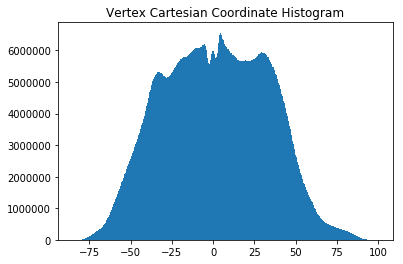

In [13]:
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
plt.hist( all_nodes, bins=500) 
plt.title('Vertex Cartesian Coordinate Histogram')
plt.show()

## 6. MinMax Normalize Input Data

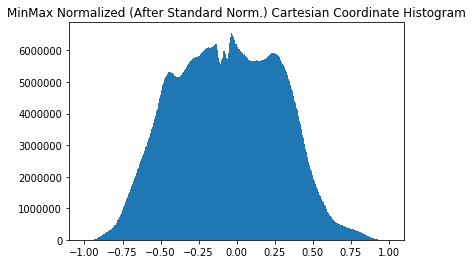

In [14]:
X_max = np.max(all_nodes)
X_min = np.min(all_nodes)

for sub in sub_graphs:
    X[sub] = (X[sub] - X_min) / (X_max - X_min)
    X[sub] *= 2
    X[sub] -= 1
    
all_nodes = np.concatenate([X[sub].flatten() for sub in sub_graphs])
plt.hist( all_nodes, bins=500) 
plt.title('MinMax Normalized (After Standard Norm.) Cartesian Coordinate Histogram')
plt.show()

del all_nodes

## 7. Block Diagonalize the Cortical Features

In [16]:
from scipy.linalg import block_diag
from sklearn.utils import resample
X = X[f"cortical"]

## 8. Split the training and validation dataset using Cross-validation

In [17]:
from sklearn.model_selection import KFold
import numpy as np

T2= [i for i in range(1332*1, 8070)]
train_index = T2 
val_index = [j for j in range(1332*0, 1332*1)]

X_train, X_val = X[train_index], X[val_index]
y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]

In [18]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(8070, 32768, 6) (8070,) (0, 32768, 6) (0,)


## 9. Load Graph Adjacencies and Convert Into Laplacians

In [19]:
L = {}
L['cortical'] = load_graph(graphs_folder=graphs_dir, prefix='M_w')
L['cortical'] = [graph.laplacian(A) for A in L['cortical']]

## 10. Block Diagonalize the Cortical Laplacians at Each Level of Coarsening

In [20]:
from scipy.sparse import block_diag as sparse_block_diag

In [21]:
new_L = []
for A in zip(L[f"cortical"]):
    new_L.append(sparse_block_diag(A))
L = new_L
del new_L

In [22]:
L

[<32768x32768 sparse matrix of type '<class 'numpy.float32'>'
 	with 228654 stored elements in Compressed Sparse Row format>,
 <16384x16384 sparse matrix of type '<class 'numpy.float32'>'
 	with 114166 stored elements in Compressed Sparse Row format>,
 <8192x8192 sparse matrix of type '<class 'numpy.float32'>'
 	with 56968 stored elements in Compressed Sparse Row format>,
 <4096x4096 sparse matrix of type '<class 'numpy.float32'>'
 	with 28398 stored elements in Compressed Sparse Row format>,
 <2048x2048 sparse matrix of type '<class 'numpy.float32'>'
 	with 14136 stored elements in Compressed Sparse Row format>,
 <1024x1024 sparse matrix of type '<class 'numpy.float32'>'
 	with 7020 stored elements in Compressed Sparse Row format>,
 <512x512 sparse matrix of type '<class 'numpy.float32'>'
 	with 3472 stored elements in Compressed Sparse Row format>,
 <256x256 sparse matrix of type '<class 'numpy.float32'>'
 	with 1706 stored elements in Compressed Sparse Row format>,
 <128x128 sparse 

## 11. ChebyNet Model Parameters Initialization

In [81]:
# Initial training parameters
params = {'num_epochs': 40, 
          'batch_size': 50,
          'eval_frequency': 10
         }

# Expected features dimension sizing of the input
N_feat = X_train.shape[-1]

params.update(task = 'regression')

if N_feat == 1:
    params['V'] = None
elif N_feat > 1:
    params['V'] = N_feat
else:
    raise ValueError('Input features dim. should be >= 1')

# # Network task initialization
# C = np.max(encoded_labels) + 1
# params.update(M = [C]) # number of units in fully-connected layer (set to # classes for classification)  
if params['task'] == 'classification':
    # Number of classes.()
    C = np.max(Gender) + 1
    assert C == np.unique(Gender).size
    params['M']              = [C]  # Set fully connected layer output to the number of class
else:
    arr = [0,0,0]
    C = np.max(arr) + 1    
    params['M']              = [C]

# Network Architecture
params['F']   = [16 for _ in range(4)] # number of filters per layer
params['K']   = 3                      # polynomial order of each layer
params['p']   = 2                      # pooling size per layer
params['B']   = len(params['F'])       # number of ResNet blocks
params['F_l'] = 128                     # number of post-ResNet filters

# Optimization Parameters
params['regularization'] = 0.
params['learning_rate']  = 5e-4
params['decay_rate']     = 0.999
params['momentum']       = 0.
params['dropout']        = 1.          # Using TF 1.13.1 so this is the KEEP PROBABILITY
params['decay_steps']    = 1.

# AUGMENTATION PROB. SET TO ZERO (NO AUGMENTATION)
params.update(prob_augment = 0.)
# Model Saving
params['dir_name'] = f"{home}/models/ABCD_CogFluidScore_cortical_only"
# os.mkdir(params['dir_name'])

## 12. Create Model

In [82]:
model = cgcnn(L, **params)

NN architecture
  input: M_0 = 32768
 
Pre-convolution layer:
  biases: L_0 * F_0_ = 32768 * 16 = 524288
  weights: V * F_0 * K_0 = 6 * 16 * 3 = 288
 
ResNet blocks:
 Block 0
    batch normalization: 2 * L_0 = 2 * 32768 = 65536
    weights: F_0 * F_0 * K_0 = 16 * 16 * 3 = 768
 Block 1
    batch normalization: 2 * L_1 = 2 * 16384 = 32768
    weights: F_1 * F_1 * K_1 = 16 * 16 * 3 = 768
 Block 2
    batch normalization: 2 * L_2 = 2 * 8192 = 16384
    weights: F_2 * F_2 * K_2 = 16 * 16 * 3 = 768
 Block 3
    batch normalization: 2 * L_3 = 2 * 4096 = 8192
    weights: F_3 * F_3 * K_3 = 16 * 16 * 3 = 768
 
Post-convolution layer:
  batch normalization: 2 * L_3 = 2 * 4096 = 8192
 
Fully connected layer:
  weights: K_3 * M = 3 * 1 = 3
L_post = 2048 ; F_post = 128 ; K_post = 3


## 13. Training

In [1]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

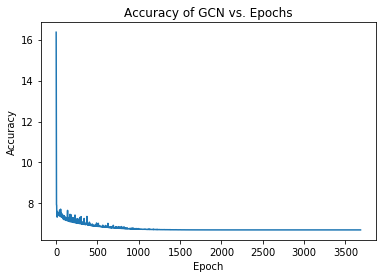

In [30]:
plt.plot(np.arange(0,1842*2,2),accuracy)
plt.title('Accuracy of GCN vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 14. CAM & Testing for each fold after training each fold

In [2]:
a = model.predict(X_train[0:1345])
np.save('path',CAM_map_a)

In [3]:
b = model.predict(X_train[1345*1:1345*2])
np.save('path',CAM_map_b)

In [4]:
c = model.predict(X_train[1345*2:1345*3])
np.save('path',CAM_map_c)

In [5]:
d = model.predict(X_train[1345*3:1345*4])
np.save('path',CAM_map_d)

In [6]:
e = model.predict(X_train[1345*4:1345*5])
np.save('path',CAM_map_e)

In [7]:
f = model.predict(X_train[1345*5:1345*6])
np.save('path',CAM_map_f)

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res = r2_score(y_train[1345*0:1345*1],a)
print('r2', res)
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_train[1345*0:1345*1],a)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_train[1345*0:1345*1],a)
print('mse', mse)


res = r2_score(y_train[1345*5:1345*6],f)
print('r2', res)
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_train[1345*5:1345*6],f)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_train[1345*5:1345*6],f)
print('mse', mse)

In [9]:
pred = np.concatenate((a,b,c,d,e,f))
print(pred.shape)
plt.plot(y_train, pred, '.')
res = r2_score(y_train,pred)
print('r2', res)

corr, p_value = pearsonr(y_train,pred)
print('corr', corr, 'p', p_value)

mse = mean_squared_error(y_train,pred)
print('mse', mse)

0.3387299112182507


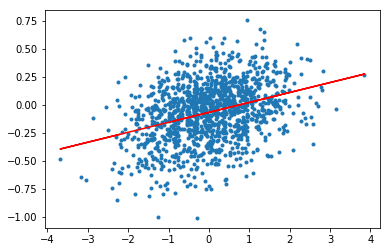

In [39]:
# predictions  = model.predict(X_val, CAM = False)
plt.plot(y_val, predictions, '.')

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_val,predictions)
# plt.plot(y_val, preds, '.')
# x = np.linspace(-2,2)
y = y_val*slope+intercept
plt.plot(y_val, y, 'r')
print(r_value)